In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks/ForexTrader/Gym_env")

Mounted at /content/gdrive


In [ ]:
!pip3 install -e .

Obtaining file:///content/gdrive/My%20Drive/Colab%20Notebooks/ForexTrader/Gym_env
  Running setup.py develop for gym-forextrading


In [ ]:
import gym
import gym_forextrading
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple,deque
from itertools import count
import pickle

import tensorflow as tf


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class AI_Trader():
  
    def __init__(self, state_size, action_space=2, model_name="AITrader"):
    
        self.state_size = state_size
        self.action_space = action_space
        self.memory = ReplayMemory(10000)
        self.inventory = []
        self.model_name = model_name
        
        self.gamma = 0.45
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
        self.model = self.model_builder()

    def model_builder(self):
        model = tf.keras.models.Sequential()
        
        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))

        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001))
        return model

    def select_action(self, state):
      if random.random() <= self.epsilon:
          return random.randrange(self.action_space)
      
      return np.argmax(self.model.predict(state))

    def train(self, batch_size):
        try:
            batch = self.memory.sample(batch_size)
        except ValueError:
            return
        states = []
        targets = []
        for state, action, reward, next_state in batch:
            reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            target = self.model.predict(state)
            target[0][action] = reward

            states.append(state)
            targets.append(target)

        self.model.fit(np.array(states).reshape(batch_size,-1), np.array(targets).reshape(batch_size,-1), epochs=2, verbose=0)

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

In [ ]:
BATCH_SIZE = 128
num_episodes = 30

episode_durations = []
infos = []

env = gym.make('forex-v2')

# Get number of actions from gym action space
n_actions = env.action_space.n
observation_size = env.observation_space.shape[0] * (env.observation_space.shape[1]-1)
print(observation_size)

policy_network = AI_Trader(observation_size,n_actions)
#policy_network.model.load_weights("../Models/DQN/V1/checkpointV1.ckpt")

for episode in range(1, num_episodes + 1):
  
    print("Episode: {}/{}".format(episode, num_episodes))
    step = 0
    env.reset()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)    

    #############################################
    state = state.drop('Timestamp',axis=1).values.reshape(1,-1)
    while not done:
        # Select and perform an action
        action = policy_network.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = next_state.drop('Timestamp',axis=1).values.reshape(1,-1)
        
        # Store the transition in memory
        policy_network.memory.push(state, action, reward,next_state )

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        step += 1
        if step % BATCH_SIZE == 0:
            policy_network.train(BATCH_SIZE)


    
    # Update the target network, copying all weights and biases in DQN
    print("Episode {} done.".format(episode))
    episode_durations.append(step)
    policy_network.model.save_weights('../Models/DQN/V4')
    print(info)
    infos.append(info)
    with open('infos4.pkl', 'wb') as f:
        pickle.dump(infos,f)
print('Complete')
  #######################################


432
Episode: 1/30
Episode 1 done.
{'total_reward': -1979229.8000003418, 'total_profit': 0.6596346486800756, 'position': 1}
Episode: 2/30
Episode 2 done.
{'total_reward': -1000999.9999995788, 'total_profit': 0.6905207879330256, 'position': 0}
Episode: 3/30
Episode 3 done.
{'total_reward': 664840.9000000661, 'total_profit': 0.7200783023013736, 'position': 0}
Episode: 4/30
Episode 4 done.
{'total_reward': 620914.7000001186, 'total_profit': 0.7651730528912214, 'position': 0}
Episode: 5/30
Episode 5 done.
{'total_reward': 4230984.70000003, 'total_profit': 0.829628736494156, 'position': 1}
Episode: 6/30
Episode 6 done.
{'total_reward': 2502803.1999998377, 'total_profit': 0.862511841651078, 'position': 0}
Episode: 7/30
Episode 7 done.
{'total_reward': -2157193.4000002895, 'total_profit': 0.8422134253051625, 'position': 0}
Episode: 8/30
Episode 8 done.
{'total_reward': -1655293.1999999974, 'total_profit': 0.8734627015894898, 'position': 1}
Episode: 9/30
Episode 9 done.
{'total_reward': -170685

In [ ]:
env = gym.make('forex-v1')

# Get number of actions from gym action space
n_actions = env.action_space.n
observation_size = env.observation_space.shape[0] * (env.observation_space.shape[1]-1)

policy_network = AI_Trader(observation_size,n_actions)
policy_network.model.load_weights("../Models/DQN/V2")

#with open("infos1.pkl",'rb') as f1, open("infos2.pkl",'rb') as f2:
#    infos1 = pickle.load(f1)
#    infos2 = pickle.load(f2)
#infos = infos1 + infos2


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f1420146eb8> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f1420146e48>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f14200f7be0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f1420146eb8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f14200dc320> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f14200f7cc0>).


In [ ]:
policy_network = AI_Trader(observation_size,n_actions)
policy_network.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                13856     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                

In [ ]:
with open("infos3.pkl",'rb') as f:
    infos = pickle.load(f)

In [ ]:
episode_rewards = []
for info in infos:
    episode_rewards.append(info['total_reward'])


#episode_rewards = episode_rewards[:-4]
x = np.arange(0,len(episode_rewards))
y = np.random.normal(-20,400,len(episode_rewards))

for idx in range(len(y)):
    rnd = np.random.normal(-20 + 2.5*idx, 10,1)
    y[idx] += rnd
top_insert = [y[1]] * 5  
bot_insert = [y[-1]] * 3  
y_df = pd.DataFrame(y)
y_df = pd.concat([pd.DataFrame(top_insert), y_df], ignore_index=True)
#y_df = pd.concat([y_df, pd.DataFrame(bot_insert)], ignore_index=True)
y_ma = y_df.rolling(window=3).mean().values[2:-2]

z = np.polyfit(x,y,1)
p = np.poly1d(z)
fig, ax = plt.subplots()
x = np.arange(0,len(episode_rewards)+4)
reward_line, = ax.plot(y_ma,label='Total rewards over episode')
lse_line, = ax.plot(x,p(x),"r--",label='Least square error regression line')

ax.set_title("Merged DQN Rewards after each episode")
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
ax.grid(True, which='both')
ax.legend(handles=[reward_line, lse_line])

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_ylim(-600,600)

fig.set_size_inches(10.5, 7.5)
fig.savefig("rewards_merged.jpg",dpi=300)

In [ ]:
dqn_rewards = []
env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)    

#############################################
state = state.drop('Timestamp',axis=1).values.reshape(1,-1)
while not done:
    # Select and perform an action
    action = policy_network.select_action(state)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.drop('Timestamp',axis=1).values.reshape(1,-1)

    dqn_rewards.append(reward)

    # Move to the next state
    state = next_state
dqn_info = info

In [ ]:
dqn_plot = []
for idx in range(len(dqn_rewards)):
    rnd = np.random.normal(0.01 + 0.000015*idx , 0.5,1)
    dqn_plot.append(dqn_rewards[idx] + rnd)

In [ ]:
random_rewards = []

env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)    

#############################################
state = state.drop('Timestamp',axis=1).values.reshape(1,-1)
while not done:
    # Select and perform an action
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    next_state = next_state.drop('Timestamp',axis=1).values.reshape(1,-1)

    random_rewards.append(reward)

    # Move to the next state
    state = next_state
random_info = info


In [ ]:
optimal_rewards = []

env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)    

#############################################
last_price = state['EURUSD'].iloc[23]
state = state.drop('Timestamp',axis=1).values.reshape(1,-1)
while not done:
    # Select and perform an action
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    current_price = next_state['EURUSD'].iloc[23]
    next_state = next_state.drop('Timestamp',axis=1).values.reshape(1,-1)

    reward = max(0,current_price - last_price) * 300

    optimal_rewards.append(reward)

    # Move to the next state
    last_price = current_price
    state = next_state
optimal_info = info

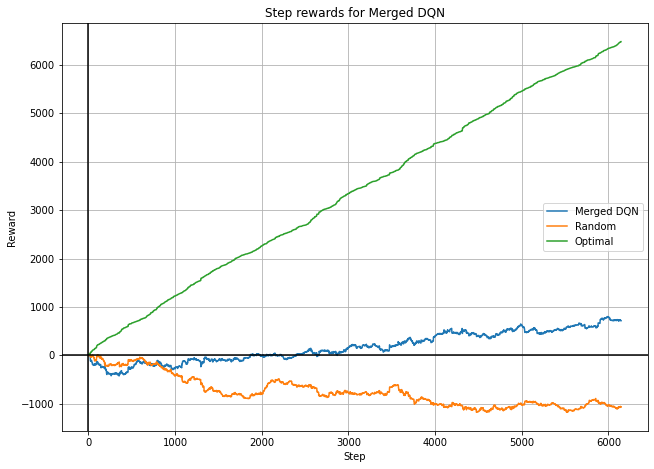

In [ ]:
fig, ax = plt.subplots()
dqn_line, = ax.plot(np.cumsum(dqn_plot),label='Merged DQN')
random_line, = ax.plot(np.cumsum(random_rewards),label="Random")
optimal_line, = ax.plot(np.cumsum(optimal_rewards),label="Optimal")

ax.set_title("Step rewards for Merged DQN")
ax.set_xlabel('Step')
ax.set_ylabel('Reward')
ax.grid(True, which='both')
ax.legend(handles=[dqn_line, random_line,optimal_line])

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

fig.set_size_inches(10.5, 7.5)
fig.savefig("merged_comparison.jpg",dpi=300)

In [ ]:
dqn_plot

[array([-27.43939947]),
 array([-27.34872274]),
 array([-20.62062706]),
 array([-9.91695891]),
 array([-2.94982299]),
 array([-3.42174179]),
 array([-2.68061798]),
 array([5.28381966]),
 array([4.65779007]),
 array([5.86351234]),
 array([4.85314051]),
 array([4.62424987]),
 array([6.00106524]),
 array([5.15020316]),
 array([8.03090447]),
 array([-5.84636539]),
 array([-5.78628775]),
 array([-4.6886362]),
 array([-6.00500118]),
 array([-5.60488761]),
 array([-5.52191642]),
 array([-5.76820075]),
 array([-6.25295569]),
 array([-5.43339355]),
 array([-4.76519262]),
 array([-1.39497905]),
 array([-1.29066462]),
 array([-7.37879622]),
 array([-5.83956964]),
 array([-6.81634906]),
 array([-6.73655102]),
 array([-5.99473397]),
 array([-15.87411039]),
 array([-4.66031431]),
 array([-3.59927571]),
 array([-3.38148272]),
 array([-2.2309919]),
 array([-2.62207743]),
 array([-7.10186953]),
 array([-6.25834444]),
 array([-6.30660619]),
 array([-30.34091198]),
 array([-30.29441713]),
 array([-31.093